# RL4CO Quickstart Notebook

<a href="https://colab.research.google.com/github/ai4co/rl4co/blob/main/examples/1-quickstart.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

[**Documentation**](https://rl4co.readthedocs.io/) |  [**Getting Started**](https://github.com/ai4co/rl4co/tree/main#getting-started) | [**Usage**](https://github.com/ai4co/rl4co/tree/main#usage) | [**Contributing**](#contributing) | [**Paper**](https://arxiv.org/abs/2306.17100) | [**Citation**](#cite-us)

In this notebook we will train the AttentionModel (AM) on the TSP environment for 20 nodes. On a GPU, this should less than 2 minutes!  🚀

![Alt text](https://user-images.githubusercontent.com/48984123/245925317-0db4efdd-1c93-4991-8f09-f3c6c1f35d60.png)

### Installation

In [35]:
## Uncomment the following line to install the package from PyPI
## You may need to restart the runtime in Colab after this
## Remember to choose a GPU runtime for faster training!

# ! pip install rl4co

In [3]:
import sys, os
sys.path.append(os.path.abspath(".."))

### Imports

In [6]:
%load_ext autoreload
%autoreload 2

import torch

from rl4co.envs import TSPEnv
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer

### Environment, Policy and Model

Full documentation of:https://rl4.co/docs/content/api/envs/base/

- Base environment class [here](https://rl4.co/docs/content/api/envs/base/)
- Base policy class [here](https://rl4.co/docs/content/api/networks/base_policies/)
- Base model class [here](https://rl4.co/docs/content/api/rl/base/)

In [8]:
# RL4CO env based on TorchRL
env = TSPEnv(generator_params={'num_loc': 50})

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(env_name=env.name, 
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8,
                            )

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env, 
                    policy,
                    baseline="rollout",
                    batch_size=512,
                    train_data_size=100_000,
                    val_data_size=10_000,
                    optimizer_kwargs={"lr": 1e-4},
                    ) 

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Note that env is a TSPEnv class. What attributes does it have? 
a generator_param dict is passed into it. 

In [46]:
td = env.reset(batch_size=[1]) 
# Since we are inheriting from RL4COENV Base, this is the default way to generate new problem instance. Now that we have passed a specified generator
# self.generator is used in the RL4COEnvBase. 
# Env.reset resets the problem instance. While env._reset resets the agent's cache
td["locs"][:,0]

tensor([[0.2344, 0.2409]])

### Test greedy rollout with untrained model and plot

Problem 1 | Cost: 20.611
Problem 2 | Cost: 22.393
Problem 3 | Cost: 20.382


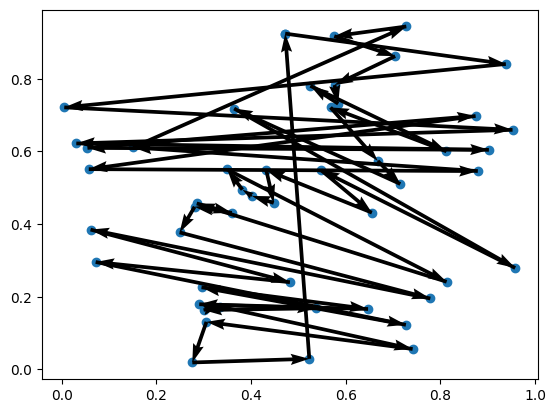

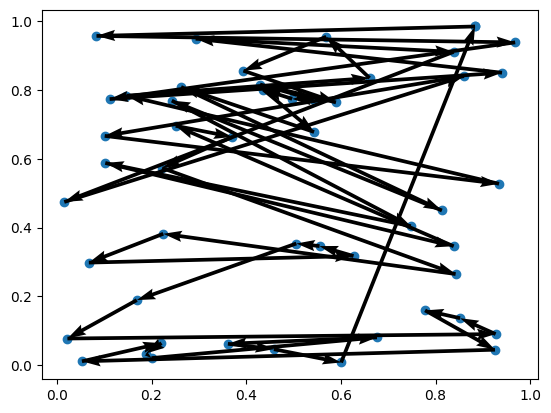

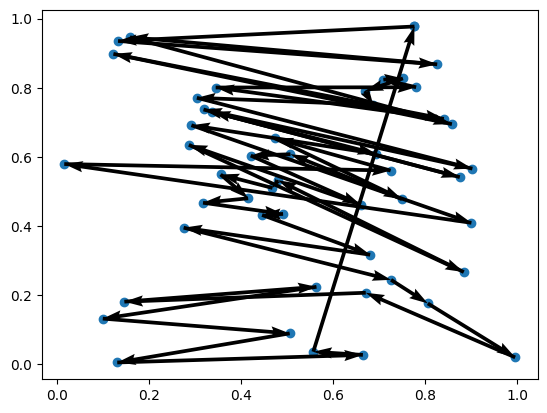

In [49]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

### Trainer

The RL4CO trainer is a wrapper around PyTorch Lightning's `Trainer` class which adds some functionality and more efficient defaults

In [52]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### Fit the model

In [55]:
trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead

  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | env      | TSPEnv               | 0      | train
1 | policy   | AttentionModelPolicy | 710 K  | train
2 | baseline | WarmupBaseline       | 710 K  | train
----------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)
72        Modules in train mode
68        Modules in eval mode


Sanity Checking: |                                          | 0/? [00:00<?, ?it/s]

Training: |                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


### Testing

In [ ]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

We can see that even after just 3 epochs, our trained AM is able to find much better solutions than the random policy! 🎉

In [13]:
# Optionally, save the checkpoint for later use (e.g. in tutorials/4-search-methods.ipynb)
trainer.save_checkpoint("tsp-quickstart.ckpt")